# Deep Learning-based Optical Character Recognition

### Credits:

This notebook has used materials from the following sources:

- © MIT 6.S191: Introduction to Deep Learning
http://introtodeeplearning.com

- Stanford CS class CS231n: Convolutional Neural Networks for Visual Recognition.
https://cs231n.github.io/


## Convolutional Neural Networks (CNNs)

Convolutional Neural Networks are very similar to ordinary Neural Networks from the previous chapter: they are made up of neurons that have learnable weights and biases. Each neuron receives some inputs, performs a dot product and optionally follows it with a non-linearity. The whole network still expresses a single differentiable score function: from the raw image pixels on one end to class scores at the other. And they still have an activation function (e.g. Softmax) on the last (fully-connected) layer and all the tips/tricks we developed for learning regular Neural Networks still apply.

So what changes? CNN architectures make the explicit assumption that the inputs are images, which allows us to encode certain properties into the architecture. These then make the forward function more efficient to implement and vastly reduce the amount of parameters in the network.


### Tensorflow 2.0

__Note:__ The code examples in this notebook utilize API from Tensorflow 2.x (not compatible with Tensorflow 1.x).

__What is Tensorflow?__

TensorFlow is a free and open-source software library for dataflow and differentiable programming across a range of tasks. It is a symbolic math library, and is also used for machine learning applications such as neural networks. It is used for both research and production at Google. 

TensorFlow was developed by the Google Brain team for internal Google use. It was released under the Apache License 2.0 on November 9, 2015. In Jan 2019, Google announced TensorFlow 2.0. It became officially available in Sep 2019.





## Part1: MNIST Digit Classification

In the first portion of this lab, we will build and train a convolutional neural network (CNN) for classification of handwritten digits from the famous [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. The MNIST dataset consists of 60,000 training images and 10,000 test images. Our classes are the digits 0-9.

First, let's download the course repository, install dependencies, and import the relevant packages we'll need for this lab.

In [2]:
# Import Tensorflow 2.0
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline

### MNIST dataset 

Let's download and load the dataset and display a few random samples from it:

In [3]:
mnist = tf.keras.datasets.mnist # The MNIST dataset comes as part of the Keras library
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = (np.expand_dims(train_images, axis=-1)/255.).astype(np.float32)
train_labels = (train_labels).astype(np.int64)
test_images = (np.expand_dims(test_images, axis=-1)/255.).astype(np.float32)
test_labels = (test_labels).astype(np.int64)

Our training set is made up of 28x28 grayscale images of handwritten digits. 

The initial dimensionality of dataset is `(num_of_images, height, width)`. For the training said that is 60000 x 28 x 28 and for the test set 10000 x 28 x 28. However, the neural network expects a fourth dimension, which is the number of channels. The statement `np.expand_dims` is used to add that extra dimenension. Here the images are grayscale so the value of the fourth dimesion is 1, so the new dimensionality becomes `(num_of_images, height, width, 1)`. If we had color images, the value would be 3 (for R-G-B). For other types of data with more channels, that value could be any integer.

Let's visualize what some of these images and their corresponding training labels look like.

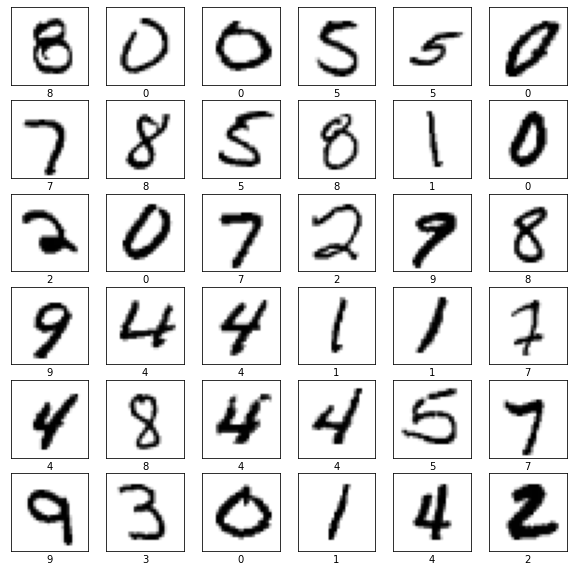

In [4]:
plt.figure(figsize=(10,10))
random_inds = np.random.choice(60000,36)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(train_images[image_ind]), cmap=plt.cm.binary)
    plt.xlabel(train_labels[image_ind])

### Neural Network for Handwritten Digit Classification

We'll first build a simple neural network consisting of two fully connected layers and apply this to the digit classification task. Our network will ultimately output a probability distribution over the 10 digit classes (0-9). This first architecture we will be building is depicted below:

![alt_text](https://raw.githubusercontent.com/aamini/introtodeeplearning/master/lab2/img/mnist_2layers_arch.png "CNN Architecture for MNIST Classification")


### Fully connected neural network architecture
To define the architecture of this first fully connected neural network, we'll once again use the Keras API and define the model using the [`Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential) class. Note how we first use a [`Flatten`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) layer, which flattens the input so that it can be fed into the model. 

In this next block, you'll define the fully connected layers of this simple work.

In [5]:
def build_fc_model():
  fc_model = tf.keras.Sequential([
      # First define a Flatten layer
      layers.Flatten(),

      # Define the activation function for the first fully connected (Dense) layer.
      layers.Dense(128, activation=tf.nn.relu),

      # Define the second Dense layer to output the classification probabilities
      layers.Dense(10, activation=tf.nn.softmax) 
  ])
  return fc_model

model = build_fc_model()

As we progress through this next portion, you may find that you'll want to make changes to the architecture defined above. **Note that in order to update the model later on, you'll need to re-run the above cell to re-initialize the model. **

Let's take a step back and think about the network we've just created. The first layer in this network, `tf.keras.layers.Flatten`, transforms the format of the images from a 2d-array (28 x 28 pixels), to a 1d-array of 28 * 28 = 784 pixels. You can think of this layer as unstacking rows of pixels in the image and lining them up. There are no learned parameters in this layer; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `tf.keras.layers.Dense` layers. These are fully-connected neural layers. The first `Dense` layer has 128 nodes (or neurons). The second (and last) layer (which you've defined!) should return an array of probability scores that sum to 1. Each node contains a score that indicates the probability that the current image belongs to one of the handwritten digit classes.

That defines our fully connected model! 



### Compile the model

Before training the model, we need to define a few more settings. These are added during the model's [`compile`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#compile) step:

* *Loss function* — This defines how we measure how accurate the model is during training. As was covered in lecture, during training we want to minimize this function, which will "steer" the model in the right direction. We will use Crossentropy loss.
* *Optimizer* — This defines how the model is updated based on the data it sees and its loss function. See [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers).
* *Metrics* — Here we can define metrics used to monitor the training and testing steps. In this example, we'll look at the *accuracy*, the fraction of the images that are correctly classified. See [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/metrics).

We'll start out by using a stochastic gradient descent (SGD) optimizer initialized with a learning rate of 0.1. Since we are performing a categorical classification task, we'll want to use the Crossentropy loss.

Note: `SparseCategoricalCrossentropy`: Computes the crossentropy loss between the labels and predictions. Use this crossentropy loss function when there are two or more label classes. We expect labels to be provided as integers. If you want to provide labels using _one-hot_ representation, please use `CategoricalCrossentropy` loss. There should be `# classes` floating point values per feature for `y_pred` and a single floating point value per feature for `y_true`.
See [Tensorflow documentation](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) for more details.

You'll want to experiment with both the choice of optimizer and learning rate and evaluate how these affect the accuracy of the trained model. 

In [7]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-1), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

Note: the parameter `from_logits` specifies if the loss should be calculated based on the output of the softmax function (i.e. in the range [0, 1]) or based on the output of a logit function (i.e. in the range [-inf, +inf]). In this case we are using a softmax activation fucntion in the output layer, so the `from_logits` parameter is set to `False`.

### Train the model

We're now ready to train our model, which will involve feeding the training data (`train_images` and `train_labels`) into the model, and then asking it to learn the associations between images and labels. We'll also need to define the batch size and the number of epochs, or iterations over the MNIST dataset, to use during training. 

In [8]:
# Define the batch size and the number of epochs to use during training
BATCH_SIZE = 64
EPOCHS = 5

history = model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    validation_data=(test_images, test_labels))

Epoch 1/5
938/938 [==============================] - 1s 1ms/step - loss: 0.3701 - accuracy: 0.8969 - val_loss: 0.2208 - val_accuracy: 0.9374
Epoch 2/5
938/938 [==============================] - 1s 1ms/step - loss: 0.1953 - accuracy: 0.9444 - val_loss: 0.1604 - val_accuracy: 0.9515
Epoch 3/5
938/938 [==============================] - 1s 1ms/step - loss: 0.1453 - accuracy: 0.9587 - val_loss: 0.1282 - val_accuracy: 0.9635
Epoch 4/5
938/938 [==============================] - 1s 1ms/step - loss: 0.1171 - accuracy: 0.9673 - val_loss: 0.1121 - val_accuracy: 0.9665
Epoch 5/5
938/938 [==============================] - 1s 1ms/step - loss: 0.0983 - accuracy: 0.9723 - val_loss: 0.1036 - val_accuracy: 0.9697


As the model trains, the loss and accuracy metrics are displayed. With five epochs and a learning rate of 0.01, this fully connected model should achieve an accuracy of approximatley 0.97 (or 97%) on the training data.

### Evaluate accuracy on the test dataset

Now that we've trained the model, we can ask it to make predictions about a test set that it hasn't seen before. In this example, the `test_images` array comprises our test dataset. To evaluate accuracy, we can check to see if the model's predictions match the labels from the `test_labels` array. 

Use the [`evaluate`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#evaluate) method to evaluate the model on the test dataset!

In [9]:
#Use the evaluate method to test the model!
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2) 

print('Test accuracy:', test_acc)

313/313 - 0s - loss: 0.1036 - accuracy: 0.9697
Test accuracy: 0.9696999788284302


We can also visulalize the training and test error for each epoch that was accumulated in `history` when we fit the model.

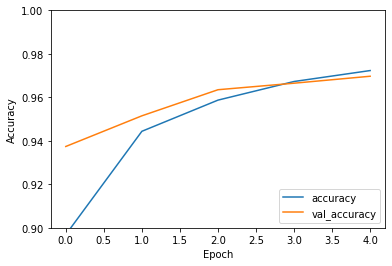

In [10]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.9, 1])
plt.legend(loc='lower right')

What is the highest accuracy you can achieve with this first fully connected model? Since the handwritten digit classification task is pretty straightforward, you may be wondering how we can do better...

![Deeper...](https://i.kym-cdn.com/photos/images/newsfeed/000/534/153/f87.jpg)

## Part 2: Convolutional Neural Network (CNN) for handwritten digit classification

As we saw in lecture, convolutional neural networks (CNNs) are particularly well-suited for a variety of tasks in computer vision, and have achieved near-perfect accuracies on the MNIST dataset. We will now build a CNN composed of two convolutional layers and pooling layers, followed by two fully connected layers, and ultimately output a probability distribution over the 10 digit classes (0-9). The CNN we will be building is depicted below:

![alt_text](https://raw.githubusercontent.com/aamini/introtodeeplearning/master/lab2/img/convnet_fig.png "CNN Architecture for MNIST Classification")

### Define the CNN model

We'll use the same training and test datasets as before, and proceed similarly as our fully connected network to define and train our new CNN model. To do this we will explore two layers we have not encountered before: you can use  [`keras.layers.Conv2D` ](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) to define convolutional layers and [`keras.layers.MaxPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) to define the pooling layers. Use the parameters shown in the network architecture above to define these layers and build the CNN model.

Our network architercture looks as follows:

- **INPUT** [28x28] will hold the raw pixel values of the image, in this case an image of width 28, height 28, and with single color channel (grayscale).
- **CONV** layer will compute the output of neurons that are connected to local regions in the input, each computing a dot product between their weights and a small region they are connected to in the input volume. This may result in volume such as [26x26x24] if we decided to use 24 filters of size [3x3].
- **RELU** layer will apply an elementwise activation function, such as the max(0,x) thresholding at zero. This leaves the size of the volume unchanged ([26x26x24]).
- **POOL** layer will perform a downsampling operation along the spatial dimensions (width, height), resulting in volume such as [13x13x24].
- **CONV** layer will compute the output of neurons that are connected to the output of the previous max-pooling layer, each computing a dot product between their weights and a small region they are connected to in the input volume. This may result in volume such as [11x11x36] if we decided to use 36 filters of size [3x3].
- **RELU** layer will apply an elementwise activation function, such as the max(0,x) thresholding at zero. This leaves the size of the volume unchanged ([11x11x36]).
- **POOL** layer will perform a downsampling operation along the spatial dimensions (width, height), resulting in volume such as [5x5x36].
- **FL** (i.e. flatten) layer will flattn the [5x5x36] into a vector of dimension 900.
- **FC** (i.e. fully-connected) layer reduce the previous 900 units to 128.
- **RELU** layer will apply an elementwise activation function, such as the max(0,x) thresholding at zero. This leaves the size of the vectore unchanged ([128]).
- **FC** (i.e. fully-connected) layer will compute the class scores, resulting in volume of size [1x1x10], where each of the 10 numbers correspond to a class score. As with ordinary Neural Networks and as the name implies, each neuron in this layer will be connected to all the numbers in the previous volume.
- The **softmax** activation function will convert the output score to a probability [0, 1].


In this way, CNNs transform the original image layer by layer from the original pixel values to the final class scores. Note that some layers contain parameters and other don’t. In particular, the CONV/FC layers perform transformations that are a function of not only the activations in the input volume, but also of the parameters (the weights and biases of the neurons). On the other hand, the RELU/POOL layers will implement a fixed function. The parameters in the CONV/FC layers will be trained with gradient descent so that the class scores that the CNN computes are consistent with the labels in the training set for each image.

In [11]:
def build_cnn_model():
    cnn_model = tf.keras.Sequential([

        # Define the first convolutional layer
        layers.Conv2D(filters=24, kernel_size=(3,3), activation=tf.nn.relu, input_shape=(28, 28, 1)),

        # Define the first max pooling layer
        layers.MaxPool2D(pool_size=(2,2)),

        # Define the second convolutional layer
        layers.Conv2D(filters=36, kernel_size=(3,3), activation=tf.nn.relu),

        # Define the second max pooling layer
        layers.MaxPool2D(pool_size=(2,2)),

        # Flatten the volume into a vector
        layers.Flatten(),
        
        # A hidden fully connected layer
        layers.Dense(128, activation=tf.nn.relu),

        # Define the last Dense layer to output the classification 
        # probabilities. Pay attention to the activation needed a probability
        # output
        layers.Dense(10, activation=tf.nn.softmax)
    ])
    
    return cnn_model
  
cnn_model = build_cnn_model()

# Print the summary of the layers in the model.
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 24)        240       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 24)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 36)        7812      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 36)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 900)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               115328    
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

### Train and test the CNN model

Now, as before, we can define the loss function, optimizer, and metrics through the `compile` method. Compile the CNN model with an optimizer and learning rate of choice:

In [12]:
#Define the compile operation with your optimizer and learning rate of choice
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

As was the case with the fully connected model, we can train our CNN using the `fit` method via the Keras API.

In [13]:
# Use model.fit to train the CNN model, with the same batch_size and number of epochs previously used.
history = cnn_model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/5
938/938 [==============================] - 10s 11ms/step - loss: 0.1910 - accuracy: 0.9420
Epoch 2/5
938/938 [==============================] - 11s 11ms/step - loss: 0.0578 - accuracy: 0.9819
Epoch 3/5
938/938 [==============================] - 11s 12ms/step - loss: 0.0404 - accuracy: 0.9874
Epoch 4/5
938/938 [==============================] - 11s 12ms/step - loss: 0.0313 - accuracy: 0.9902
Epoch 5/5
938/938 [==============================] - 11s 12ms/step - loss: 0.0261 - accuracy: 0.9912


Great! Now that we've trained the model, let's evaluate it on the test dataset using the [`evaluate`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#evaluate) method:

In [14]:
# Use the evaluate method to test the model!
test_loss, test_acc = cnn_model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.0378 - accuracy: 0.9882
Test accuracy: 0.9882000088691711


What is the highest accuracy you're able to achieve using the CNN model, and how does the accuracy of the CNN model compare to the accuracy of the simple fully connected network? What optimizers and learning rates seem to be optimal for training the CNN model? 

### Make predictions with the CNN model

With the model trained, we can use it to make predictions about some images. The [`predict`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#predict) function call generates the output predictions given a set of input samples.


In [15]:
predictions = cnn_model.predict(test_images)

With this function call, the model has predicted the label for each image in the testing set. Let's take a look at the prediction for the first image in the test dataset:

In [16]:
predictions[0]

array([1.4939351e-07, 1.3725472e-07, 1.4349070e-05, 1.8228804e-05,
       2.3561640e-08, 2.7063978e-09, 7.7479310e-13, 9.9996233e-01,
       8.9261412e-08, 4.6947516e-06], dtype=float32)

As you can see, a prediction is an array of 10 numbers. Recall that the output of our model is a probability distribution over the 10 digit classes. Thus, these numbers describe the model's "confidence" that the image corresponds to each of the 10 different digits. 

Let's look at the digit that has the highest confidence for the first image in the test dataset:

In [17]:
# Identify the digit with the highest confidence prediction for the first image in the test dataset.
prediction = np.argmax(predictions[0]) 

print(prediction)

7


So, the model is most confident that this image is a "7". We can check the test label (remember, this is the true identity of the digit) to see if this prediction is correct:

Label of this digit is: 7


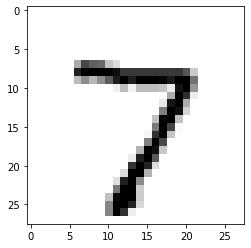

In [18]:
print("Label of this digit is:", test_labels[0])
plt.imshow(test_images[0,:,:,0], cmap=plt.cm.binary)

### Layers

The most common form of a CNNs architecture stacks a few CONV-RELU layers, follows them with POOL layers, and repeats this pattern until the image has been merged spatially to a small size. At some point, it is common to transition to fully-connected layers. The last fully-connected layer holds the output, such as the class scores. In other words, the most common CNNs architecture follow the pattern:

`INPUT -> [[CONV -> RELU]*N -> POOL?]*M -> [FC -> RELU]*K -> FC`

where the `*` indicates repetition, and the `POOL?` indicates an optional pooling layer. Moreover, `N >= 0` (and usually `N <= 3`), `M >= 0`, `K >= 0` (and usually `K < 3`). For example, here are some common CNN architectures you may see that follow this pattern:

- `INPUT -> FC`, implements a linear classifier. Here `N = M = K = 0`.
- `INPUT -> CONV -> RELU -> FC`
- `INPUT -> [CONV -> RELU -> POOL]*2 -> FC -> RELU -> FC`. Here we see that there is a single CONV layer between every POOL layer.
- `INPUT -> [CONV -> RELU -> CONV -> RELU -> POOL]*3 -> [FC -> RELU]*2 -> FC` Here we see two CONV layers stacked before every POOL layer. This is generally a good idea for larger and deeper networks, because multiple stacked CONV layers can develop more complex features of the input volume before the destructive pooling operation.

## Conclusion
In this notebook, you had the chance to play with different MNIST classifiers with different architectures (fully-connected layers only, CNN), and experiment with how different hyperparameters affect accuracy (learning rate, etc.).

A similar example with using the CIFAR10 dataset for color image classification:
https://www.tensorflow.org/tutorials/images/cnn